In [1]:
# Cell 1: Import all required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
import os
import glob

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline  

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Cell 2: Find and connect to the database
def find_database():
    """Find the database file"""
    print("Searching for database file...")
    
    # Check common locations
    possible_locations = [
        "data/rental_data.db",           # If notebook is in project root
        "../data/rental_data.db",        # If notebook is in a subfolder
        "./rental_data.db",              # If database is in current folder
        "../../data/rental_data.db",     # If notebook is two levels deep
    ]
    
    for location in possible_locations:
        if os.path.exists(location):
            print(f"Found database at: {os.path.abspath(location)}")
            return location
    
    # If not found, search recursively
    print("Database not in common locations. Searching entire project...")
    for file in glob.glob("**/rental_data.db", recursive=True):
        if os.path.exists(file):
            print(f"✓ Found database at: {os.path.abspath(file)}")
            return file
    
    print("Could not find rental_data.db")
    print("Please run 'python main.py' first to create the database")
    return None

def connect_to_db():
    """Connect to the database"""
    db_path = find_database()
    if db_path is None:
        return None
    
    try:
        conn = sqlite3.connect(db_path)
        print("✓ Successfully connected to database!")
        return conn
    except Exception as e:
        print(f"✗ Error connecting to database: {e}")
        return None

# Test the connection
print("Testing database connection...")
conn = connect_to_db()

Testing database connection...
Searching for database file...
Found database at: /home/tvarben/Stockholm_Rental_Price_Tracker/data/rental_data.db
Successfully connected to database


In [3]:
# Cell 3: Load and preview data
def load_data(conn):
    """Load data from database"""
    if conn is None:
        print("No database connection")
        return None
    
    try:
        query = "SELECT * FROM housing"
        df = pd.read_sql_query(query, conn)
        print(f"✓ Loaded {len(df)} rental listings")
        return df
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return None

def preprocess_data(df):
    """Clean and prepare the data"""
    if df is None:
        return None
    
    df_clean = df.copy()
    
    # Convert to numeric types
    df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
    df_clean['size_kvm'] = pd.to_numeric(df_clean['size_kvm'], errors='coerce')
    
    # Calculate price per square meter
    df_clean['price_per_sqm'] = df_clean['price'] / df_clean['size_kvm']
    
    # Remove extreme outliers (keep middle 98%)
    price_lower = df_clean['price'].quantile(0.01)
    price_upper = df_clean['price'].quantile(0.99)
    df_clean = df_clean[(df_clean['price'] >= price_lower) & 
                        (df_clean['price'] <= price_upper)]
    
    # Clean location names
    df_clean['location_clean'] = df_clean['location'].str.title()
    
    print("✓ Data preprocessing completed")
    return df_clean

# Load and preprocess the data
if conn:
    df = load_data(conn)
    df_clean = preprocess_data(df)
    
    # Show preview
    if df_clean is not None:
        print("\nFirst 5 rows of data:")
        display(df_clean.head())
        
        print("\nBasic statistics:")
        print(df_clean[['price', 'size_kvm', 'price_per_sqm']].describe())
else:
    print("Cannot load data without database connection")

Loaded 1669 rental listings
Data preprocessing completed

First 5 rows of data:


,id,location,address,property_type,size_kvm,price,available,until,url,price_per_sqm,location_clean
0,1,Stockholm,Ängskärsgatan,Lägenhet,90,28606,2025-08-05,Tillsvidare,https://bostad.blocket.se/sv/home/1167649,317.844444,Stockholm
1,2,Spånga,Skogängsvägen,Lägenhet,49,12714,2025-09-21,2026-06-01,https://bostad.blocket.se/sv/home/1167828,259.469388,Spånga
2,3,Spånga,Storvretsvägen,Lägenhet,40,7946,2025-08-05,Tillsvidare,https://bostad.blocket.se/sv/home/1167703,198.650000,Spånga
3,4,Hägersten,Lina Sandells plan,Lägenhet,25,12184,2025-10-01,Tillsvidare,https://bostad.blocket.se/sv/home/1167847,487.360000,Hägersten
4,5,Stockholm,Drejargatan,Lägenhet,49,19600,2025-09-01,2026-02-28,https://bostad.blocket.se/sv/home/1167822,400.000000,Stockholm



Basic statistics:
              price     size_kvm  price_per_sqm
count   1635.000000  1635.000000    1635.000000
mean   14446.327829    47.028135     368.897823
std     7794.686805    31.252287     376.720265
min     4198.000000     1.000000      47.041379
25%     8476.000000    25.000000     249.813592
50%    13455.000000    41.000000     335.800000
75%    17772.500000    60.000000     446.017857
max    47227.000000   250.000000   14303.000000


In [4]:
# Cell 4: Visualization setup functions
def sek_formatter(x, pos):
    """Format numbers as Swedish Krona"""
    return f'SEK {x:,.0f}'

sek_format = FuncFormatter(sek_formatter)

print("Visualization functions ready")

Visualization functions ready


Creating price distribution visualization.


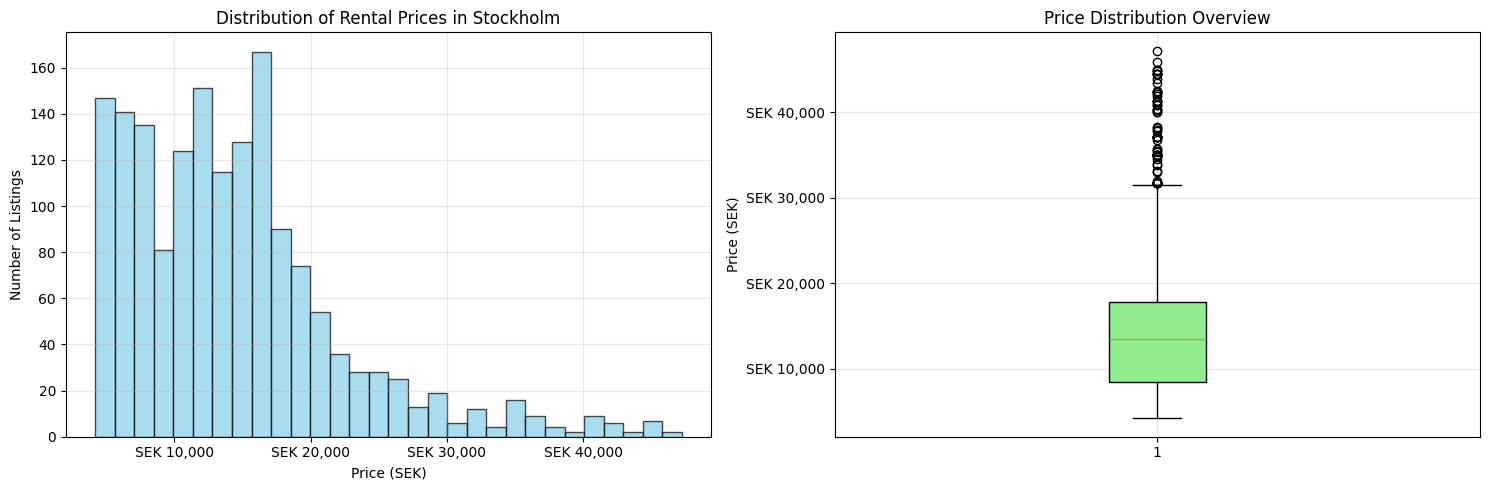

In [5]:
# Cell 5: Price distribution visualization
def plot_price_distribution(df):
    """Plot distribution of rental prices"""
    if df is None or df.empty:
        print("No data to plot")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(df['price'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.set_xlabel('Price (SEK)')
    ax1.set_ylabel('Number of Listings')
    ax1.set_title('Distribution of Rental Prices in Stockholm')
    ax1.xaxis.set_major_formatter(sek_format)
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(df['price'].dropna(), patch_artist=True,
                boxprops=dict(facecolor='lightgreen'))
    ax2.set_ylabel('Price (SEK)')
    ax2.set_title('Price Distribution Overview')
    ax2.yaxis.set_major_formatter(sek_format)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create the plot
print("Creating price distribution visualization...")
plot_price_distribution(df_clean)

Creating price by location visualization...


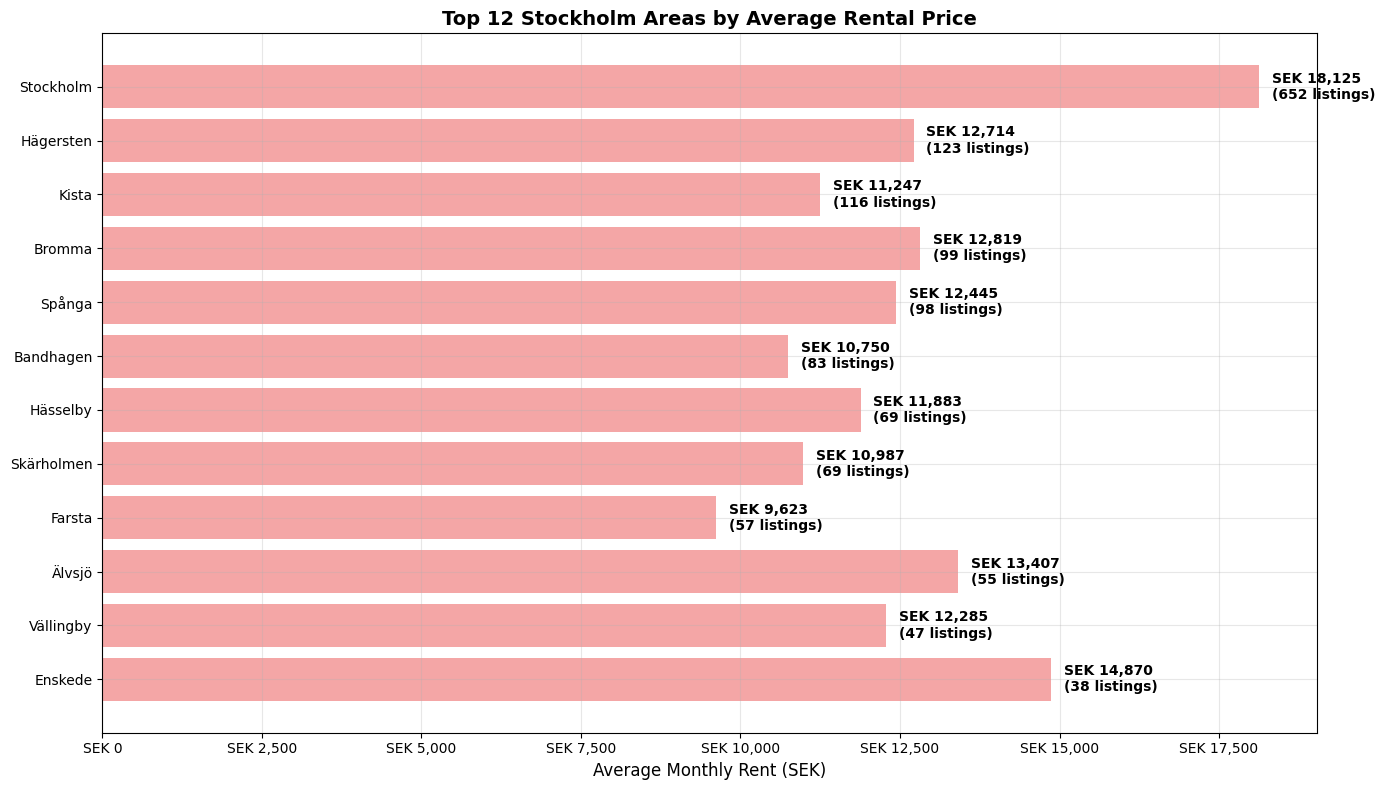

In [6]:
# Cell 6: Price by location visualization
def plot_price_by_location(df, top_n=12):
    """Plot average prices by location"""
    if df is None or df.empty:
        print("No data to plot")
        return
    
    # Calculate average price by location
    location_stats = df.groupby('location_clean').agg({
        'price': ['mean', 'count']
    }).round(0)
    
    # Flatten column names
    location_stats.columns = ['avg_price', 'count']
    
    # Filter locations with at least 3 listings
    location_stats = location_stats[location_stats['count'] >= 3]
    
    # Get top N locations by count
    top_locations = location_stats.nlargest(top_n, 'count')
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.barh(range(len(top_locations)), top_locations['avg_price'], 
                   color='lightcoral', alpha=0.7)
    
    ax.set_xlabel('Average Monthly Rent (SEK)', fontsize=12)
    ax.set_title(f'Top {top_n} Stockholm Areas by Average Rental Price', fontsize=14, fontweight='bold')
    ax.xaxis.set_major_formatter(sek_format)
    ax.set_yticks(range(len(top_locations)))
    ax.set_yticklabels(top_locations.index)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (price, count) in enumerate(zip(top_locations['avg_price'], top_locations['count'])):
        ax.text(price + 200, i, f'SEK {price:,.0f}\n({count} listings)', 
                va='center', fontsize=10, fontweight='bold')
    
    plt.gca().invert_yaxis()  # Highest price at top
    plt.tight_layout()
    plt.show()

# Create the plot
print("Creating price by location visualization...")
plot_price_by_location(df_clean)

Creating price vs size visualization...


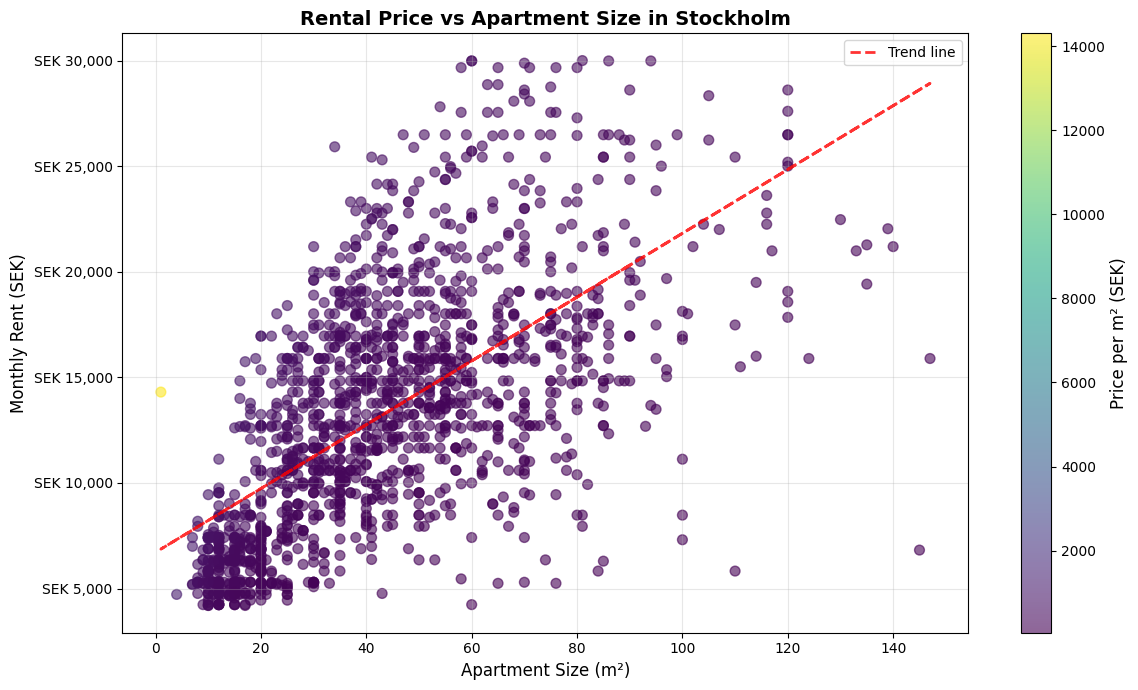

In [7]:
# Cell 7: Price vs Size scatter plot
def plot_price_vs_size(df):
    """Scatter plot of price vs apartment size"""
    if df is None or df.empty:
        print("No data to plot")
        return
    
    # Filter for better visualization
    filtered = df[(df['size_kvm'] < 150) & (df['price'] < 30000)].dropna()
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    scatter = ax.scatter(filtered['size_kvm'], filtered['price'], 
                        alpha=0.6, c=filtered['price_per_sqm'], 
                        cmap='viridis', s=50)
    
    ax.set_xlabel('Apartment Size (m²)', fontsize=12)
    ax.set_ylabel('Monthly Rent (SEK)', fontsize=12)
    ax.set_title('Rental Price vs Apartment Size in Stockholm', fontsize=14, fontweight='bold')
    ax.yaxis.set_major_formatter(sek_format)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Price per m² (SEK)', fontsize=12)
    
    # Add trend line
    z = np.polyfit(filtered['size_kvm'], filtered['price'], 1)
    p = np.poly1d(z)
    ax.plot(filtered['size_kvm'], p(filtered['size_kvm']), "r--", 
            alpha=0.8, linewidth=2, label='Trend line')
    
    ax.legend()
    plt.tight_layout()
    plt.show()

# Create the plot
print("Creating price vs size visualization...")
plot_price_vs_size(df_clean)

Creating property type distribution visualization...


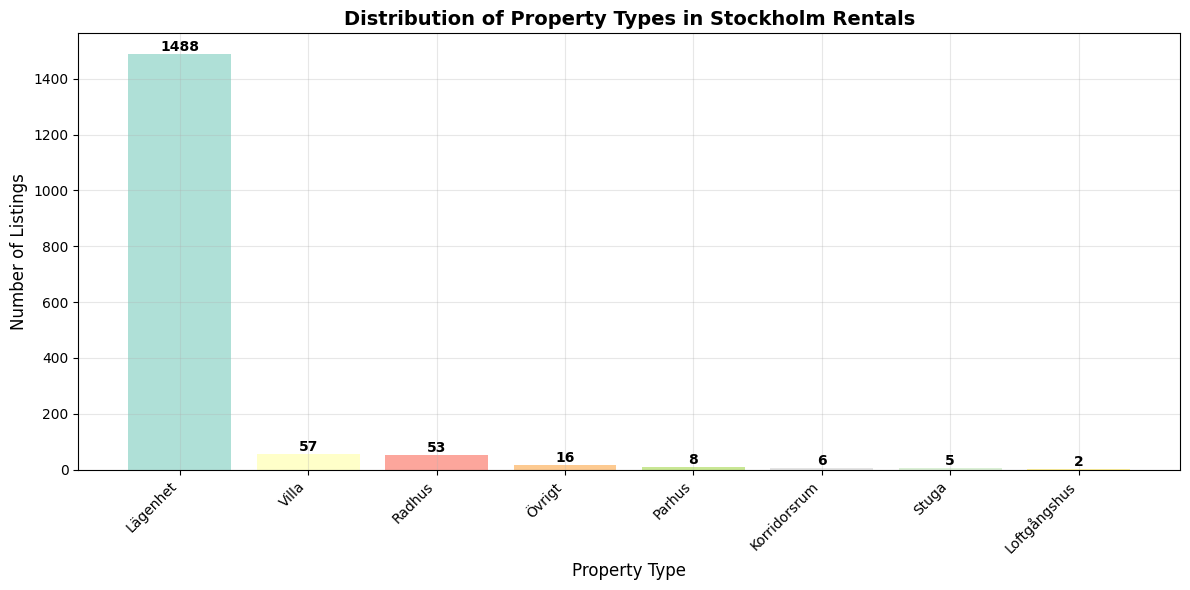

In [8]:
# Cell 8: Property type distribution
def plot_property_type_distribution(df):
    """Plot distribution of property types"""
    if df is None or df.empty:
        print("No data to plot")
        return
    
    prop_type_counts = df['property_type'].value_counts()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.Set3(np.linspace(0, 1, len(prop_type_counts)))
    bars = ax.bar(range(len(prop_type_counts)), prop_type_counts.values, 
                  color=colors, alpha=0.7)
    
    ax.set_xlabel('Property Type', fontsize=12)
    ax.set_ylabel('Number of Listings', fontsize=12)
    ax.set_title('Distribution of Property Types in Stockholm Rentals', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(prop_type_counts)))
    ax.set_xticklabels(prop_type_counts.index, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, count in enumerate(prop_type_counts.values):
        ax.text(i, count + 0.5, str(count), ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Create the plot
print("Creating property type distribution visualization...")
plot_property_type_distribution(df_clean)

In [9]:
# Cell 9: Clean up - close database connection
if conn:
    conn.close()
    print("✓ Database connection closed")
else:
    print("No database connection to close")

print("\n All visualizations completed")
print("\nNext steps:")
print("1. Run 'python main.py' if you need to update your data")
print("2. Re-run this notebook to see updated visualizations")

✓ Database connection closed

Visualizations completed.

Next steps:
1. Run 'python main.py' if you need to update your data
2. Re-run this notebook to see updated visualizations
